# 1. PCA

In [1]:
import numpy as np

## 1.1 sklearn

In [2]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

### 1.1.1 load data

In [3]:
X = load_iris().data
y = load_iris().target

### 1.1.2 Init PCA and two principal components

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

### 1.1.3 Visualize

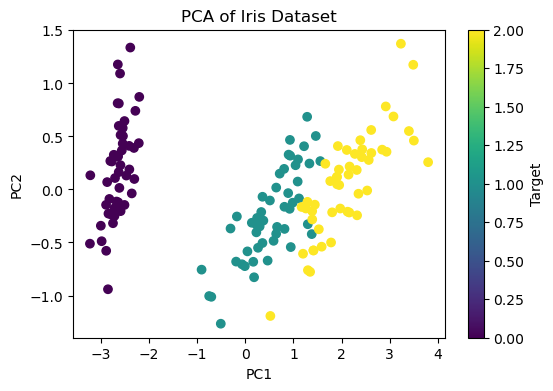

In [5]:
plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="viridis")
plt.title("PCA of Iris Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Target")
plt.show()

In [6]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

## 1.2 Numpy

In [7]:
class PCA_Numpy:
    def __init__(self, n_components, use_svd=True):
        self.n_components = n_components
        self.components_ = None #principal components (eigenvectors)
        self.mean_ = None # mean of each feature
        self.explained_variance_ratio_ = None
        self.use_svd = use_svd

    def fit(self, X):
        #step1 mean and centered
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        #consider use SVD or covariance
        if self.use_svd:
            #step2 use SVD
            U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
            self.components_ = Vt[:self.n_components]
    
            explained_variance = (S ** 2) / (X.shape[0] - 1)
            total_variance = explained_variance.sum()
            self.explained_variance_ratio_ = explained_variance[:self.n_components] / total_variance

        else:
            #step2 covariance matrix
            cov_matrix = np.cov(X_centered, rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            sorted_idx = np.argsort(eigenvalues)[::-1]
            topk_vectors = eigenvectors[:, sorted_idx[:self.n_components]]
            topk_values = eigenvalues[sorted_idx[:self.n_components]]
            self.components_ = topk_vectors.T
            self.explained_variance_ratio_ = topk_values / eigenvalues.sum()

    def transform(self, X):
        X_centered = X - self.mean_
        return X_centered @ self.components_.T

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

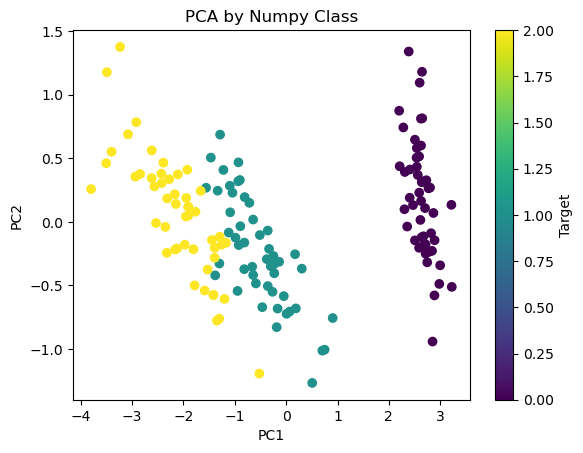

In [8]:
pca_numpy = PCA_Numpy(n_components=2, use_svd=False)
X_pca_numpy = pca_numpy.fit_transform(X)

# 可视化结果
plt.scatter(X_pca_numpy[:, 0], X_pca_numpy[:, 1], c=y, cmap='viridis')
plt.title("PCA by Numpy Class")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Target")
plt.show()

## 1.3 Pytorch

In [9]:
import torch

class PCA_Torch:
    def __init__(self, n_components, device=None):
        self.n_components = n_components
        self.device = device or "cpu"
        self.components_ = None #principal components (eigenvectors)
        self.mean_ = None # mean of each feature
        self.explained_variance_ratio_ = None

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)

        self.mean_ = X.mean(dim=0)
        X_centered = X - self.mean_

        U, S, Vh = torch.linalg.svd(X_centered, full_matrices=False)

        self.components_ = Vh[:self.n_components]
        explained_variance = (S ** 2) / (X.shape[0] - 1)
        total_variance = explained_variance.sum()
        self.explained_variance_ratio_ = explained_variance[:self.n_components] / total_variance

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        X_centered = X - self.mean_
        return torch.matmul(X_centered, self.components_.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

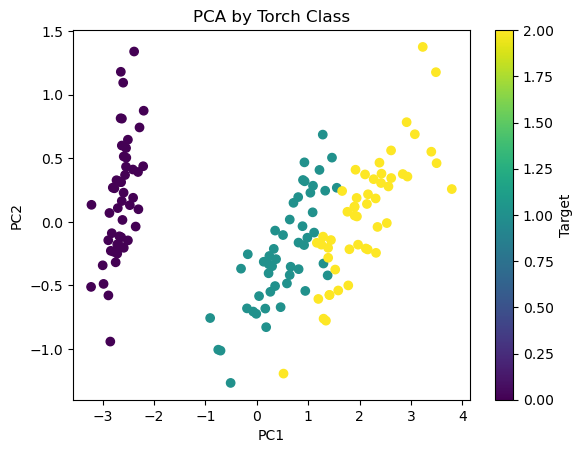

In [10]:
pca_torch = PCA_Torch(n_components=2)
X_pca_torch = pca_torch.fit_transform(X)

# 可视化结果
plt.scatter(X_pca_torch[:, 0], X_pca_numpy[:, 1], c=y, cmap='viridis')
plt.title("PCA by Torch Class")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Target")
plt.show()

# 2. DBSCAN

## 2.1 Sklearn

In [11]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

### 2.1.1 Load data

In [12]:
X, y = make_moons(n_samples=300, noise=0.05, random_state=42)

### 2.1.2 fit

In [13]:
db = DBSCAN(eps=0.2, min_samples=5)
y_pred = db.fit_predict(X)

### 2.1.3 visualize

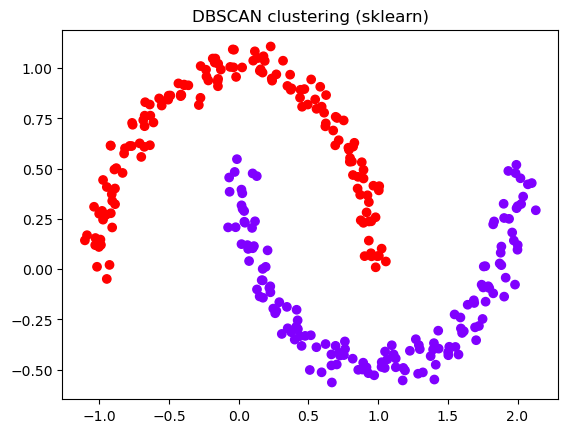

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='rainbow')
plt.title("DBSCAN clustering (sklearn)")
plt.show()

## 2.2 numpy

In [15]:
from collections import deque

In [16]:
class DBSCAN_Numpy:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit(self, X):
        n = X.shape[0]
        self.labels_ = np.full(n, -1) #initialize all to -1
        visited = np.zeros(n, dtype=bool)
        cluster_id = 0

        for i in range(n):
            if visited[i]:
                continue

            visited[i] = True
            neighbors = self.region_query(X, i)
            if len(neighbors) < self.min_samples:
                continue #noise
            else:
                #expand
                self.expand_cluster(X, i, neighbors, cluster_id, visited)
                cluster_id += 1

    def region_query(self, X, index):
        """find neighbours of some sample in the range of eps"""
        dists = np.linalg.norm(X - X[index], axis=1)
        return np.where(dists <= self.eps)[0]

    def expand_cluster(self, X, point_idx, neighbors, cluster_id, visited):
        """from the key point to expand whole cluster"""
        self.labels_[point_idx] = cluster_id
        queue = deque(neighbors)

        while queue:
            curr = queue.popleft()
            if not visited[curr]:
                visited[curr] = True
                curr_neighbors = self.region_query(X, curr)
                if len(curr_neighbors) >= self.min_samples:
                    queue.extend(curr_neighbors)

            if self.labels_[curr] == -1:
                self.labels_[curr] = cluster_id

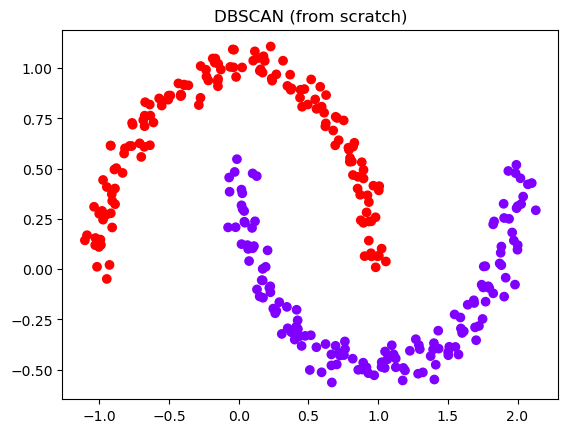

In [17]:
# 自定义 DBSCAN
db = DBSCAN_Numpy(eps=0.2, min_samples=5)
db.fit(X)
y_pred = db.labels_

# 可视化
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='rainbow')
plt.title("DBSCAN (from scratch)")
plt.show()

# 3. t-SNE (t-Distributed Stochastic Neighbor Embedding)

## 3.1 Sklearn

In [18]:
from sklearn.manifold import TSNE

In [19]:
X, y = load_iris(return_X_y=True)

In [20]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)

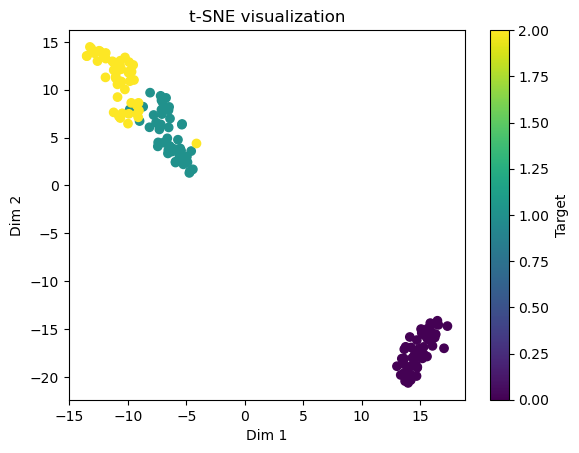

In [21]:
# 可视化
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title("t-SNE visualization")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar(label='Target')
plt.show()

## 3.2 Numpy TSNE

t-SNE 的完整实现非常复杂（包含高斯分布、学生分布、梯度优化、早期夸大等技巧）；

这里我们将实现 基础简化版，用于学习目的

In [25]:
class TSNE_Numpy:
    def __init__(self, n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=1000, random_state=42):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state
        self.embedding_ = None #store the dimension reduction result

    def _compute_pairwise_distances(self, X):
        sum_X = np.sum(np.square(X), axis=1)
        dists = np.add.outer(sum_X, sum_X) - 2 * np.dot(X, X.T)
        #same to in KNN
        #sum_X = np.sum(np.square(X), axis=1).reshape(-1, 1)  # shape (m, 1)
        #sum_Y = np.sum(np.square(Y), axis=1).reshape(1, -1)  # shape (1, n)
        #dists = sum_X + sum_Y - 2 * np.dot(X, Y.T)  # shape (m, n)
        return dists

    def _H_beta(self, Di, beta):
        P = np.exp(-Di * beta)
        sumP = np.sum(P)
        P = P / sumP
        H = -np.sum(P * np.log(P + 1e-8))
        return H, P

    def _compute_P(self, distances):
        n = distances.shape[0]
        P = np.zeros((n, n))
        beta = np.ones(n)
        log_perp = np.log(self.perplexity)

        for i in range(n):
            betamin, betamax = -np.inf, np.inf
            Di = distances[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
            H, thisP = self._H_beta(Di, beta[i])
            H_diff = H - log_perp
            tries = 0

            while np.abs(H_diff) > 1e-5 and tries < 50:
                if H_diff > 0:
                    betamin = beta[i]
                    beta[i] = beta[i]*2 if betamax == np.inf else (beta[i] + betamax)/2
                else:
                    betamax = beta[i]
                    beta[i] = beta[i]/2 if betamin == -np.inf else (beta[i] + betamin)/2
                H, thisP = self._H_beta(Di, beta[i])
                H_diff = H - log_perp
                tries += 1

            P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

        P = (P + P.T) / (2.0 * n)
        return np.clip(P, 1e-12, None)

    def _compute_Q(self, Y):
        num = 1 / (1 + self._compute_pairwise_distances(Y))
        np.fill_diagonal(num, 0)
        Q = num / np.sum(num)
        return Q, num

    def fit_transform(self, X):
        np.random.seed(self.random_state)
        X = X - np.mean(X, axis=0)  # 中心化
        n, d = X.shape

        distances = self._compute_pairwise_distances(X)
        P = self._compute_P(distances)
        P *= 4.0  # early exaggeration

        Y = np.random.randn(n, self.n_components) * 1e-4
        Y_inc = np.zeros_like(Y)
        momentum = 0.5

        for iter in range(self.n_iter):
            Q, num = self._compute_Q(Y)
            Q = np.clip(Q, 1e-12, None)
            PQ_diff = P - Q

            dY = np.zeros_like(Y)
            for i in range(n):
                dY[i] = np.sum(np.expand_dims(PQ_diff[:, i] * num[:, i], 1) * (Y[i] - Y), axis=0)

            Y_inc = momentum * Y_inc - self.learning_rate * dY
            Y += Y_inc

            if iter == 100:
                momentum = 0.8
                P /= 4.0

            if iter % 100 == 0:
                C = np.sum(P * np.log(P / Q))
                print(f"[iter {iter}] KL divergence: {C:.4f}")

        self.embedding_ = Y
        return Y

[iter 0] KL divergence: 11.6597
[iter 100] KL divergence: 0.7125
[iter 200] KL divergence: 0.1486
[iter 300] KL divergence: 0.1402
[iter 400] KL divergence: 0.1364


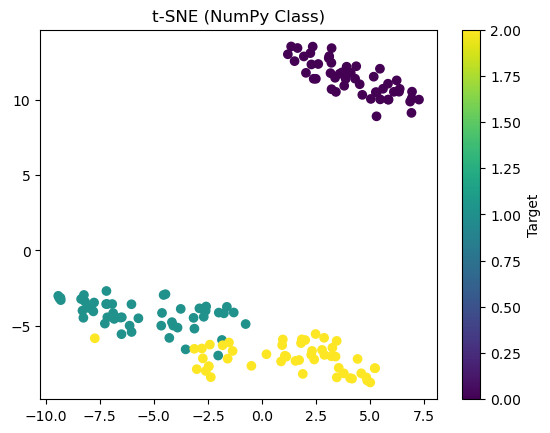

In [26]:
tsne = TSNE_Numpy(n_components=2, perplexity=30, learning_rate=200, n_iter=500)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title("t-SNE (NumPy Class)")
plt.colorbar(label='Target')
plt.show()

# 4. UMAP (Uniform Manifold Approximation and Projection)

In [22]:
import umap.umap_ as umap

In [23]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X)

/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


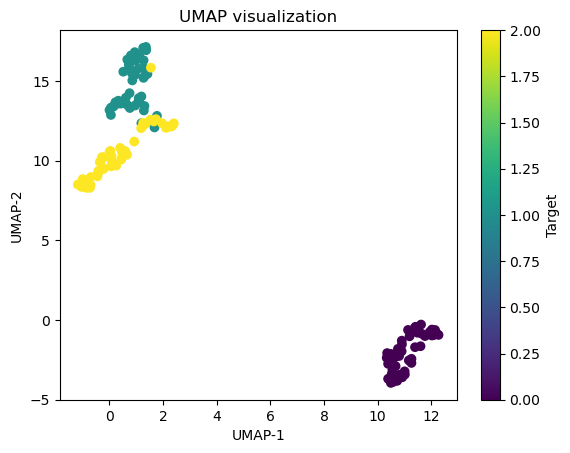

In [24]:
# 可视化
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='viridis')
plt.title("UMAP visualization")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label='Target')
plt.show()